Version: 02.14.2023

# Implementing Topic Extraction with NTM

## 1. Fetching the dataset

In [1]:
!pip install --upgrade pip
!pip install --upgrade SageMaker
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: SageMaker
    Found existing installation: sagemaker 2.237.0
    Uninstalling sagemaker-2.237.0:
      Successfully uninstalled sagemaker-2.237.0


In [2]:
import boto3
import os
import shutil

def check_create_dir(dir):
    if os.path.exists(dir):  # Clean up existing data folder
        shutil.rmtree(dir)
    os.mkdir(dir)

data_dir = '20_newsgroups'
check_create_dir(data_dir)

In [3]:
!tar -xzf ../s3/20_newsgroups.tar.gz
!ls 20_newsgroups

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med


In [4]:
folders = [os.path.join(data_dir,f) for f in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, f))]
file_list = [os.path.join(d,f) for d in folders for f in os.listdir(d)]
print('Number of documents:', len(file_list))

Number of documents: 19997


## 2. Examining and preprocessing the data

In [5]:
!cat 20_newsgroups/comp.graphics/37917

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!andrey
From: andrey@cco.caltech.edu (Andre T. Yew)
Newsgroups: comp.graphics
Subject: Re: 16 million vs 65 thousand colors
Date: 3 Apr 1993 19:51:06 GMT
Organization: California Institute of Technology, Pasadena
Lines: 28
Message-ID: <1pkpraINNck9@gap.caltech.edu>
References: <1993Mar26.210323.27802@midway.uchicago.edu> <dotzlaw-020493084300@murphy.biochem.umanitoba.ca> <d9hh.733845825@dtek.chalmers.se>
NNTP-Posting-Host: punisher.caltech.edu

d9hh@dtek.chalmers.se (Henrik Harmsen) writes:

>1-4 bits per R/G/B gives horrible machbanding visible in almost any picture.

>5 bits per R/G/B (32768, 65000 colors) gives visible machbanding

>color-gradient picture has _almost_ no machbanding. This color-resolution is 

>see some small machbanding on the smooth color-gradient picture, but all in all,
>There _ARE_ situiations where 

In [6]:
import re
def strip_newsgroup_header(text):
    """
    Given text in "news" format, strip the headers, by removing everything
    before the first blank line.
    """
    _before, _blankline, after = text.partition('\n\n')
    return after

_QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                       r'|^In article|^Quoted from|^\||^>)')


def strip_newsgroup_quoting(text):
    """
    Given text in "news" format, strip lines beginning with the quote
    characters > or |, plus lines that often introduce a quoted section
    (for example, because they contain the string 'writes:'.)
    """
    good_lines = [line for line in text.split('\n')
                  if not _QUOTE_RE.search(line)]
    return '\n'.join(good_lines)


def strip_newsgroup_footer(text):
    """
    Given text in "news" format, attempt to remove a signature block.

    As a rough heuristic, we assume that signatures are set apart by either
    a blank line or a line made of hyphens, and that it is the last such line
    in the file (disregarding blank lines at the end).
    """
    lines = text.strip().split('\n')
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip('-') == '':
            break

    if line_num > 0:
        return '\n'.join(lines[:line_num])
    else:
        return text

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...


In [8]:
stop = stopwords.words('english')
lem = WordNetLemmatizer()

def clean(sent):
    # Implement this function
    sent = sent.lower()
    sent = re.sub('\s+', ' ', sent)
    sent = sent.strip()
    sent = re.compile('<.*?>').sub('',sent)
    # Remove special characters and digits
    sent=re.sub("(\\d|\\W)+"," ",sent)
    sent=re.sub("br","",sent)
    filtered_sentence = []
    
    for w in word_tokenize(sent):
        # You are applying custom filtering here. Feel free to try different things.
        # Check if it is not numeric, the length > 2, and it is not in stopwords.
        if(not w.isnumeric()) and (len(w)>2) and (w not in stop):  
            # Stem and add to filtered list
            filtered_sentence.append(lem.lemmatize(w))
    final_string = " ".join(filtered_sentence) # Final string of cleaned words
    return final_string

In [10]:
import nltk
nltk.download('punkt_tab')

data = []
source_group = []
for f in file_list:
    with open(f, 'rb') as fin:
        content = fin.read().decode('latin1')   
        content = strip_newsgroup_header(content)
        content = strip_newsgroup_quoting(content)
        content = strip_newsgroup_footer(content)
        content = clean(content)
        # Remove header, quoting, and footer
        data.append(content)
        

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
data[10:13]

['somebody reconcile apparent contradiction',
 'look math different possible frame reference find time physically relevant relevant time falling object center hole evil singularity lurks singularity horizon appearance one come attempting use coordinate system map properly physically geometry rather analogous singularity north south pole earth using latitude longitude line singular behavior earlier post suggested infinite time reach horizon mathematical artifact wrong choice coordinate paul say object frame reference hit horizon finite time plunge singularity real singularity short small hole finite amount time outside observer object fall black hole disappears finite time also spite relativistic slow intuition suggests light emitted object fall shone onto separate flashlight consists individual finite quantum finite number reach object plunge horizon succesively red shifted true finite number hit object following one late interact object inside horizon thus come reddening dimming disap

In [12]:
%%time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')

# vectorizer = CountVectorizer(input='content', max_features=vocab_size, max_df=0.95, min_df=2)
vectorizer = CountVectorizer(input='content', max_features=vocab_size)
vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names_out()

print('vocab size:', len(vocab_list))

Tokenizing and counting, this may take a few minutes...
vocab size: 2000
CPU times: user 1.42 s, sys: 23.8 ms, total: 1.44 s
Wall time: 1.54 s


In [13]:
threshold = 25
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print('removed short docs (<{} words)'.format(threshold))        
print(vectors.shape)

removed short docs (<25 words)
(10866, 2000)


In [14]:
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse._csr.csr_matrix'> int64
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 35 stored elements and shape (1, 2000)>
  Coords	Values
  (0, 643)	1
  (0, 89)	1
  (0, 1498)	1
  (0, 304)	1
  (0, 730)	1
  (0, 1271)	2
  (0, 2)	1
  (0, 288)	1
  (0, 1970)	1
  (0, 550)	1
  (0, 1584)	1
  (0, 1985)	1
  (0, 975)	1
  (0, 1632)	2
  (0, 1316)	1
  (0, 857)	1
  (0, 1878)	1
  (0, 947)	1
  (0, 969)	1
  (0, 625)	1
  (0, 1217)	1
  (0, 79)	2
  (0, 1810)	1
  (0, 1447)	1
  (0, 1326)	1
  (0, 553)	1
  (0, 1979)	1
  (0, 629)	2
  (0, 603)	1
  (0, 1313)	1
  (0, 380)	1
  (0, 176)	1
  (0, 1161)	1
  (0, 818)	1
  (0, 1780)	1


In [15]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse._csr.csr_matrix'> float32


# 3. Preparing the data for training


In [16]:
from sklearn.model_selection import train_test_split
def split_data(df):
    train, test_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_validate,
                                            test_size=0.5,
                                            shuffle=True,
                                            random_state=324
                                            )
    return train, validate, test

In [17]:
train_vectors, val_vectors, test_vectors = split_data(vectors)

In [18]:
print(train_vectors.shape, val_vectors.shape)

(8692, 2000) (1087, 2000)


In [19]:
import os
import shutil
aux_data_dir = os.path.join(data_dir, 'auxiliary')
check_create_dir(aux_data_dir)
with open(os.path.join(aux_data_dir, 'vocab.txt'), 'w', encoding='utf-8') as f:
    for item in vocab_list:
        f.write(item+'\n')


In [20]:
import os
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket = "c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/02/25 14:19:27] INFO     Found credentials from IAM Role:                                   ]8;id=274781;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=730008;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[01/02/25 14:19:30] INFO     Found credentials from IAM Role:                                   ]8;id=568617;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=971288;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=935112;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=501842;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [21]:
prefix = '20newsgroups-ntm'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
aux_prefix = os.path.join(prefix, 'auxiliary')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
s3_aux_data = os.path.join('s3://', bucket, aux_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Auxiliary data location', s3_aux_data)
print('Trained model will be saved at', output_path)

Training set location s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train
Validation set location s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/val
Auxiliary data location s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/auxiliary
Trained model will be saved at s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/output


In [22]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to S3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [23]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

[01/02/25 14:19:31] INFO     Found credentials from IAM Role:                                   ]8;id=725040;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=430867;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part0.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part1.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part2.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part3.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part4.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part5.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part6.pbr
Uploaded data to s3://c144486a3735947l8877953t1w515664268277-labbucket-zpp8yk1j1swm/20newsgroups-ntm/train/train_part7.pbr
Uploaded data to

Upload the vocab.txt file.

In [24]:
boto3.resource('s3').Bucket(bucket).Object(aux_prefix+'/vocab.txt').upload_file(aux_data_dir+'/vocab.txt')

# 4. Training the model

In [25]:
from sagemaker.image_uris import retrieve
container = retrieve('ntm',boto3.Session().region_name)

[01/02/25 14:19:33] INFO     Same images used for training and inference. Defaulting to image     ]8;id=694573;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=541350;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=522167;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=753736;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

In [26]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=2, 
                                    instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker.Session())

In [27]:
num_topics = 20
ntm.set_hyperparameters(num_topics=num_topics, 
                        feature_dim=vocab_size, 
                        mini_batch_size=256, 
                        num_patience_epochs=10, 
                        optimizer='adam')

In [28]:
from sagemaker.inputs import TrainingInput
# sagemaker.inputs.TrainingInput
s3_train = TrainingInput(s3_train_data, distribution='ShardedByS3Key') 
s3_val = TrainingInput(s3_val_data, distribution='FullyReplicated')

In [29]:
s3_aux = TrainingInput(s3_aux_data, distribution='FullyReplicated', content_type='text/plain')

In [30]:
# ntm.fit({'train': s3_train, 'validation': s3_train, 'auxiliary': s3_aux})
ntm.fit({'train': s3_train, 'validation': s3_val, 'auxiliary': s3_aux})

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=837469;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=950015;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: ntm-2025-01-02-14-19-33-485           ]8;id=228542;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=557983;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-01-02 14:19:35 Starting - Starting the training job...
2025-01-02 14:19:48 Starting - Preparing the instances for training...
2025-01-02 14:20:23 Downloading - Downloading input data...
2025-01-02 14:20:53 Downloading - Downloading the training image..............Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[01/02/2025 14:23:21 INFO 140326446733120] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid', 'optimizer': 'adadelta', 'tolerance': '0.001', 'num_patience_epochs': '3', 'batch_norm': 'false', 'rescale_gradient': '1.0', 'clip_gradient': 'Inf', 'weight_decay': '0.0', 'learning_rate': '0.01', 'sub_sample': '1.

In [31]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2025-01-02-14-19-33-485


# 5. Using the model for inference

In [32]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

[01/02/25 14:24:52] INFO     Creating model with name: ntm-2025-01-02-14-24-52-724                  ]8;id=525821;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=17987;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/02/25 14:24:53] INFO     Creating endpoint-config with name ntm-2025-01-02-14-24-52-724         ]8;id=886255;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=90969;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name ntm-2025-01-02-14-24-52-724                ]8;id=784620;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=592570;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

---------!

In [33]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint_name))

Endpoint name: ntm-2025-01-02-14-24-52-724


In [34]:
ntm_predictor.content_types = 'text/csv'
ntm_predictor.serializer = sagemaker.serializers.CSVSerializer()
ntm_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [35]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

{'predictions': [{'topic_weights': [0.0285607204, 0.0283888634, 0.0276503507, 0.0265486818, 0.028436251, 0.1183940321, 0.02682852, 0.031554468, 0.0228114463, 0.026353756, 0.3909858763, 0.0278479382, 0.0201163869, 0.0170920528, 0.0288172457, 0.0299206227, 0.0286323559, 0.0347958691, 0.029213259, 0.0270513315]}, {'topic_weights': [0.0403987467, 0.0466345251, 0.0315666497, 0.0481342413, 0.0529025681, 0.0721594989, 0.043630451, 0.096203208, 0.0398576595, 0.0432687439, 0.0749193579, 0.0611620843, 0.0411004312, 0.0225771163, 0.0447615013, 0.0482342131, 0.0522308871, 0.0550781488, 0.0469710529, 0.0382089727]}, {'topic_weights': [0.0339993574, 0.0322222151, 0.026659444, 0.0242393184, 0.0334757455, 0.0281056836, 0.0296673626, 0.0329169855, 0.214009583, 0.0336993188, 0.0240020659, 0.0334413163, 0.2368113697, 0.0165919587, 0.0337385982, 0.0340107493, 0.0366512872, 0.0313425697, 0.0326330103, 0.031782072]}, {'topic_weights': [0.0102366572, 0.0103070112, 0.0108868778, 0.0136450883, 0.0118093695, 0.

In [36]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.02856072 0.02838886 0.02765035 0.02654868 0.02843625 0.11839403
  0.02682852 0.03155447 0.02281145 0.02635376 0.39098588 0.02784794
  0.02011639 0.01709205 0.02881725 0.02992062 0.02863236 0.03479587
  0.02921326 0.02705133]
 [0.04039875 0.04663453 0.03156665 0.04813424 0.05290257 0.0721595
  0.04363045 0.09620321 0.03985766 0.04326874 0.07491936 0.06116208
  0.04110043 0.02257712 0.0447615  0.04823421 0.05223089 0.05507815
  0.04697105 0.03820897]
 [0.03399936 0.03222222 0.02665944 0.02423932 0.03347575 0.02810568
  0.02966736 0.03291699 0.21400958 0.03369932 0.02400207 0.03344132
  0.23681137 0.01659196 0.0337386  0.03401075 0.03665129 0.03134257
  0.03263301 0.03178207]
 [0.01023666 0.01030701 0.01088688 0.01364509 0.01180937 0.01144894
  0.01157532 0.77068841 0.01081983 0.00911714 0.01595645 0.01391762
  0.01673725 0.01096076 0.01092615 0.01191523 0.01184355 0.0113205
  0.01174391 0.01414398]
 [0.03928871 0.04431721 0.02792398 0.03004135 0.04854349 0.05887995
  0.04386482 0.066

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
colnames = pd.DataFrame({'topics':['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6','topic 7','topic 8','topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'topic 15', 'topic 16','topic 17','topic 18','topic 19']})

[01/02/25 14:30:02] INFO     generated new fontManager                                         ]8;id=665485;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=593913;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1584\1584]8;;\

Text(0.5, 0, 'Topic ID')

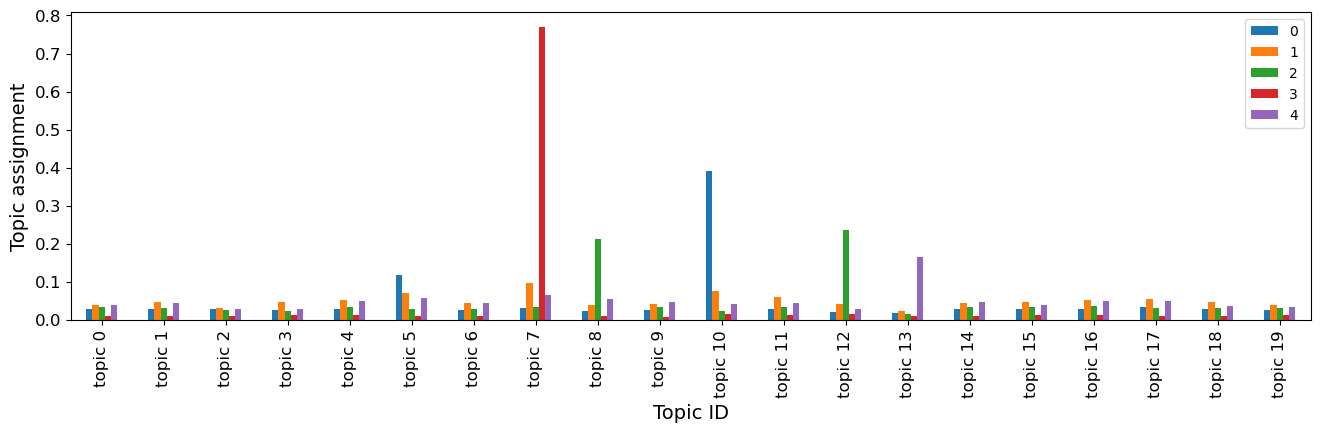

In [38]:
fs = 12
df=pd.DataFrame(predictions.T)
df.index = colnames['topics']
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [39]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

[01/02/25 14:30:04] INFO     Deleting endpoint with name: ntm-2025-01-02-14-24-52-724               ]8;id=457997;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=102461;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\

# 6. Exploring the model

In [52]:
# If you use the conda_mxnet_p36 kernel, MXNet is already installed; otherwise, uncomment the following line to install it.
!pip install mxnet 

import numpy as onp
onp.bool = bool

import mxnet as mx


In [53]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'20newsgroups-ntm/output/ntm-2025-01-02-14-19-33-485/output/model.tar.gz'

In [54]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [55]:
!tar -xzvf 'downloaded_model.tar.gz'

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model_algo-2
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model_algo-1


In [56]:
# Use flag -o to overwrite the previously unzipped content
!unzip -o model_algo-2

Archive:  model_algo-2
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [57]:
model = mx.ndarray.load('params')

W = model['arg:projection_weight']

In [58]:
print(W)


[[ 0.00149398 -0.28141925 -0.33352903 ... -0.34633526  0.13909367
   0.37230346]
 [ 0.05236189 -0.03922059  0.03162093 ...  0.06234651 -0.00582944
  -0.01846832]
 [ 0.05728943  0.09106312 -0.23786148 ...  0.00658409  0.04506185
  -0.00891115]
 ...
 [ 0.06103899 -0.08327505  0.13959047 ... -0.05839053  0.01621229
   0.04186129]
 [-0.31598404 -0.11140695 -0.5849848  ... -0.12247545 -0.3725144
  -0.4793376 ]
 [-0.10462059 -0.0636454  -0.00696119 ... -0.38690603 -0.20945513
  -0.01158592]]
<NDArray 2000x20 @cpu(0)>


In [59]:
!pip install wordcloud
import wordcloud as wc

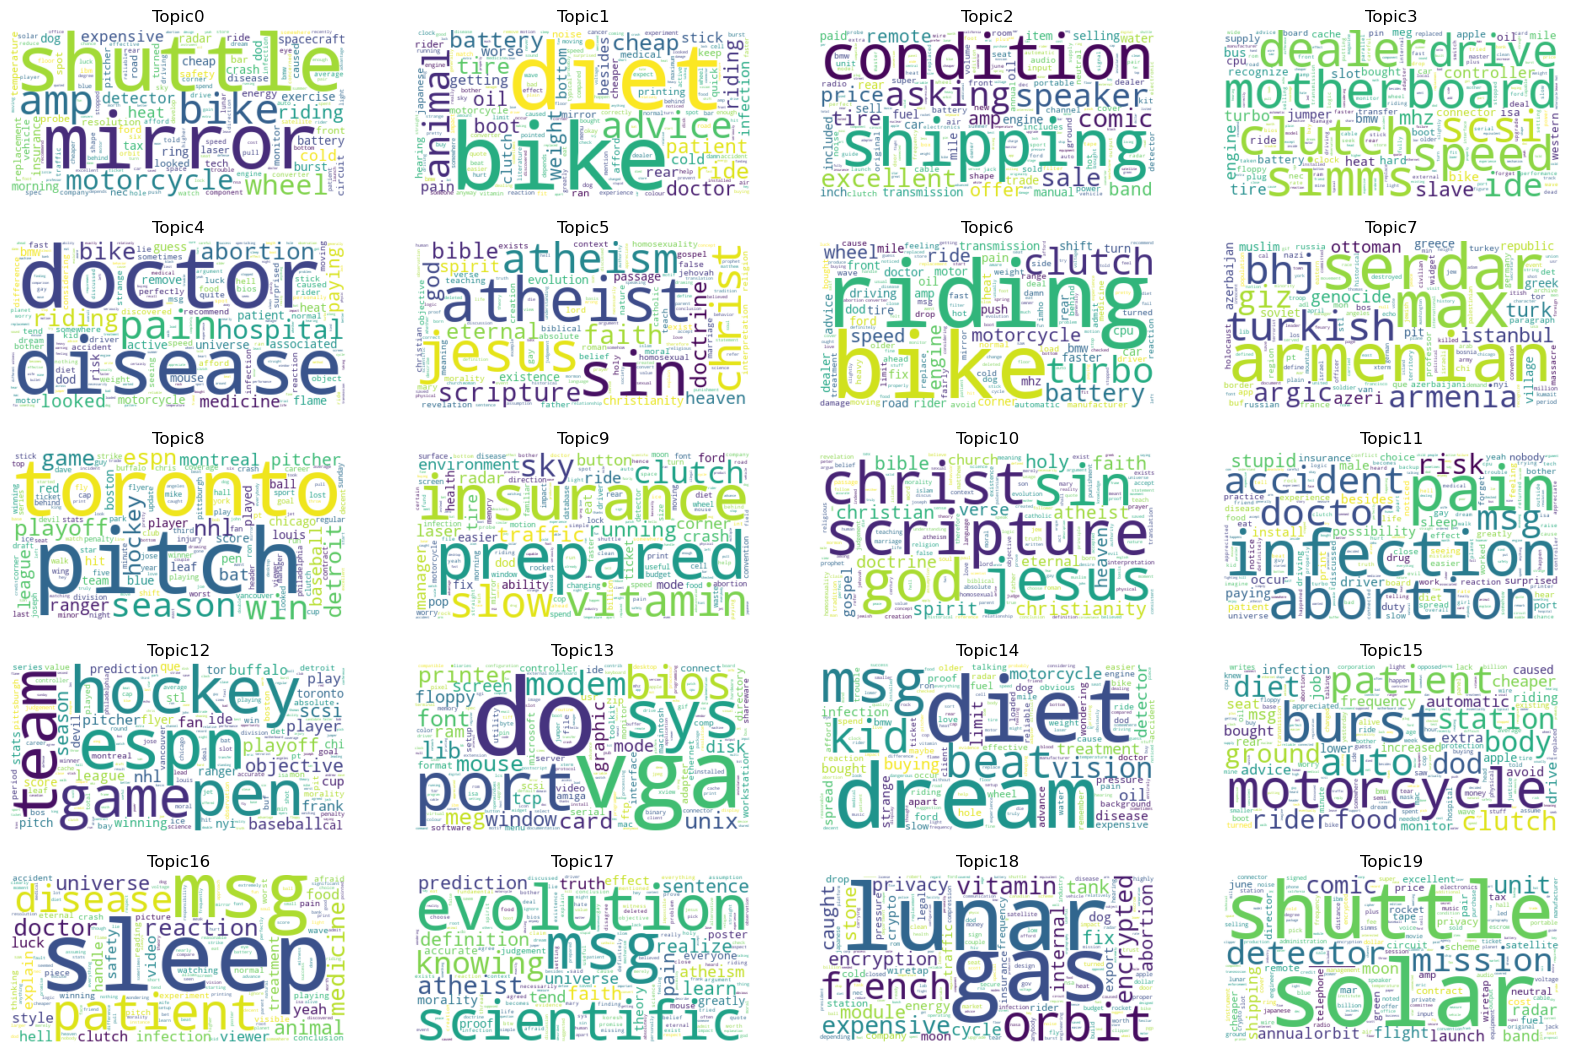

In [60]:
import matplotlib.pyplot as plt
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1